In [13]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [14]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2015-01-01') & (geo_fire_data['acq_date'] < '2021-01-1')]

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['fireID'].count().reset_index()


<ipython-input-15-ee5bc2da00d9>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


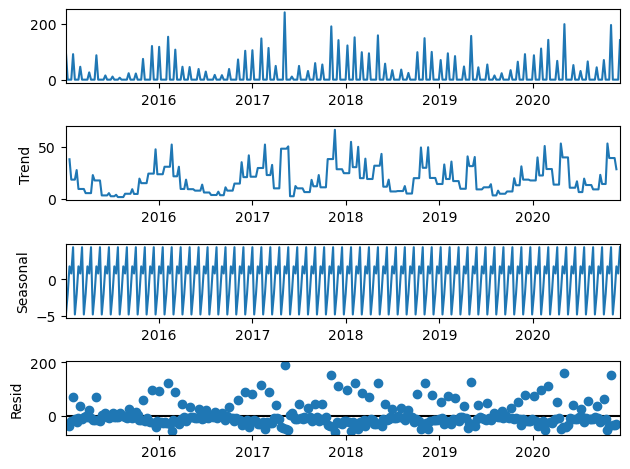

In [45]:
geo_fire_data['day'] = 1
geo_fire_data['year'] = pd.Series(pd.to_numeric(geo_fire_data['year'], errors='coerce'), dtype='int64')
geo_fire_data['month'] = pd.Series(pd.to_numeric(geo_fire_data['month'], errors='coerce'), dtype='int64')
geo_fire_data['ModifiedDateTime'] = pd.to_datetime(geo_fire_data[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

#Sort the values based on time
fires_count = geo_fire_data.sort_values(by=['ModifiedDateTime'])
fires_count = fires_count.set_index(pd.to_datetime(fires_count.pop('ModifiedDateTime'))).resample('W')['fireID'].count()
fires_count = fires_count.to_frame()

result_year = seasonal_decompose(fires_count, model='additive', period = 5)
result_year.plot()
plt.show()

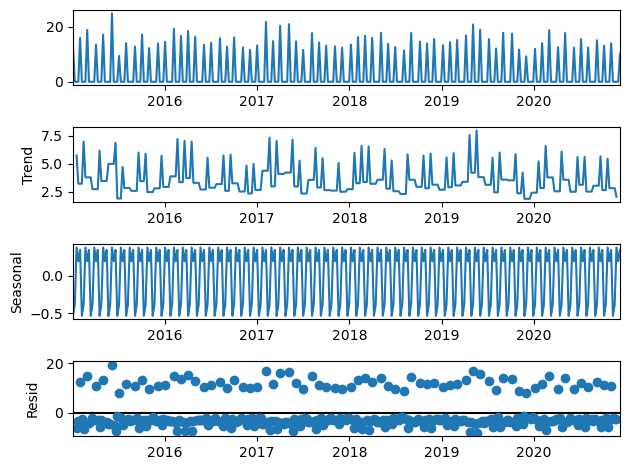

In [53]:
#Sort the values based on time
fires_count = geo_fire_data.sort_values(by=['ModifiedDateTime'])
fires_count = fires_count.set_index(pd.to_datetime(fires_count.pop('ModifiedDateTime'))).resample('W')['frp'].mean()
fires_count = fires_count.to_frame()
fires_count = fires_count.fillna(0)

result_year = seasonal_decompose(fires_count, model='additive', period = 5)
result_year.plot()
plt.show()
